HERE I AM ADDING THE REQUIRED LIBRARIES FOR LATER ON OPERATIONS 

In [1]:
from nltk.stem import WordNetLemmatizer
import nltk
import pandas as pd
from nltk import pos_tag
from nltk.tokenize import word_tokenize
import string
from collections import defaultdict
import math
import json
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score


DOWN BELOW IVE DEFINED THE PRE-PROCESSING AND POST-PROCESSING FUNCTIONS .I.E THE METRICS FUNCTIONS AND THE TEXT PROCESSING FUNCTIONS

In [2]:
l=WordNetLemmatizer()
def lemmatize_word(word):
    tokens = word_tokenize(word)
    pos_tags = pos_tag(tokens)
    pos_tag_word = pos_tags[0][1]
    pos_map = {
        'N': 'n',  # Noun
        'V': 'v',  # Verb
        'R': 'r',  # Adverb
        'J': 'a'   # Adjective
    }
    pos = pos_map.get(pos_tag_word[0], 'n')
    lemma = l.lemmatize(word, pos=pos)
    return lemma
def remove_punctuation(line):
    translator = str.maketrans('', '', string.punctuation)
    cleaned_line = line.translate(translator)
    return cleaned_line
def process_text(text):
    text = text.lower()
    text = remove_punctuation(text)
    words = text.split()
    return [lemmatize_word(word) for word in words]

def update_counts(dictionary, key, index,index_set):
    if key in dictionary:
        dictionary[key][index] += 1
    else:
        dictionary[key] = [0] * len(index_set)
        dictionary[key][index] += 1

def optimize_counts(text, index_set, dictionary):
    processed_words = process_text(text)
    for word, part_of_speech in processed_words:
        key = (word, part_of_speech)
        update_counts(dictionary, key, index_set)
def probabilities(freq,n,v):
    return (freq+1)/(n+v)
'''def calculate_accuracy(true_labels, predicted_labels):
    correct_predictions = [1 if true == pred else 0 for true, pred in zip(true_labels, predicted_labels)]
    accuracy = sum(correct_predictions) / len(true_labels)
    return accuracy

def maximize_accuracy(df, true_label_column, predicted_score_column):

    best_threshold = 0
    best_accuracy = 0

    true_labels = df[true_label_column]
    predicted_scores = df[predicted_score_column]

    thresholds = np.linspace(min(predicted_scores), max(predicted_scores), 100)
    for threshold in thresholds:
        predicted_labels = [ 1 if score > threshold else 0 for score in predicted_scores]
        accuracy = calculate_accuracy(true_labels, predicted_labels)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    return best_threshold, best_accuracy'''


def find_optimal_threshold(df, true_label_column, predicted_score_column, metric_func):
    true_labels = df[true_label_column]
    predicted_scores = df[predicted_score_column]

    thresholds = np.linspace(min(predicted_scores), max(predicted_scores), 100)
    
    best_threshold = 0
    best_metric = 0

    for threshold in thresholds:
        predicted_labels = (predicted_scores > threshold).astype(int)
        metric_value = metric_func(true_labels, predicted_labels)
        if metric_value > best_metric:
            best_metric = metric_value
            best_threshold = threshold

    return best_threshold, best_metric




def calculate_sum(text,word_to_number,prior):
    words = process_text(text)
    net=prior
    for word in words:
        try:
            n=word_to_number[word]
        except:
            n=0
        net+=n
    return net

    
def predicted(threshold,score):
    if threshold>score:
        return 0
    else :
        return 1
    



In [3]:
def evaluate_classification(df,actual_col,predicted_col='predicted'):
    # Calculate Metrics
    roc_auc = roc_auc_score(df[actual_col], df[predicted_col])
    f1 = f1_score(df[actual_col], df[predicted_col])
    conf_matrix = confusion_matrix(df[actual_col], df[predicted_col])

    # Plot Confusion Matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(df[actual_col], df[predicted_col])
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    # Display Metrics
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('Confusion Matrix:')
    print(conf_matrix)

In [4]:
def scores(lll,df,tc,bc,prior):
    df["Score"]=df[tc].apply(lambda x: calculate_sum(x,lll,prior))
    best_threshold, highest_accuracy = find_optimal_threshold(df, bc, "Score", accuracy_score)
    print(f"The best threshold is {best_threshold:.4f} with an accuracy of {highest_accuracy:.2%}")
    best_threshold_f1, best_f1_score = find_optimal_threshold(df, bc, "Score", f1_score)
    print(f"The best threshold for F1 score is {best_threshold_f1:.4f} with an F1 score of {best_f1_score:.2f}")
    best_threshold_roc_auc, best_roc_auc_score = find_optimal_threshold(df,  bc, "Score", roc_auc_score)
    print(f"The best threshold for ROC AUC is {best_threshold_roc_auc:.4f} with a ROC AUC of {best_roc_auc_score:.2f}")
    df['predicted'] = df['Score'].apply(lambda x: predicted(best_threshold, x))
    evaluate_classification(df,actual_col=bc)
    df['predicted'] = df['Score'].apply(lambda x: predicted(best_threshold_f1, x))
    evaluate_classification(df,actual_col=bc)
    df['predicted'] = df['Score'].apply(lambda x: predicted(best_threshold_roc_auc, x))
    evaluate_classification(df,actual_col=bc)
    

HERE I SET UP SENTIWORD NET SO THAT IN CASE WE ONLY WANT THE WORDS PRESENT IN SENTIWORD NET WE HAVE A WAY TO PICK THOSE THAT SUIT US

In [5]:
sentiwordnet=pd.read_csv("s2.csv")
sentiwordnet['c2'] = sentiwordnet['c2'].fillna('').astype(str)
sentiwordnet['c2'] = sentiwordnet['c2'].apply(lambda x: lemmatize_word(x) if x else x)
sentiwordnet['c2'] = sentiwordnet['c2'].apply(lambda x: x[0] if isinstance(x, tuple) else x)
sentiwordnet.drop(columns='Unnamed: 0.2', inplace=True)
sentiwordnet.drop(columns='Unnamed: 0.1', inplace=True)
sentiwordnet.drop(columns='Unnamed: 0', inplace=True)
sentiwordnet.drop(columns='ID', inplace=True)
sentiwordnet.drop(columns='SynsetTerms', inplace=True)
sentiwordnet.drop(columns='cleaned_synsets', inplace=True)
sentiwordnet.drop(columns='# POS', inplace=True)
sentiwordnet.drop(columns='PosScore', inplace=True)
sentiwordnet.drop(columns='NegScore', inplace=True)
sentiwordnet.drop(columns='Gloss', inplace=True)


In [6]:
sentiwordnet.head()

,c2
0,able
1,unable
2,dorsal
3,abaxial
4,ventral


ONE SIMPLE FUNCTION TO COMPLETELY PROCESS DATASET FROM START TO FINISH. IT TAKES IN DATAFRAME,BIAS,COLUMN NAME, TEXT COLUMN NAME, FILE NAME TO DUMP THE FREQEUNCY DICT , FILE NAME TO DUMP THE LOGLIKELIHOOD, FILE NAME TO DUMP THE LOGPRIOR AND FINALLY VARIABLE TO SET THE SENTI TOT TRUE OR FALSE(THIS CAN BE MODIFIED SO THAT WE ONLY TAKE IN WORDS WE WANT)

In [7]:
def standard(df,biascol,textcol,freqname="freqlist.txt",likelihoodname="biaswordnet.txt",logpriorname="logprior.txt",senti=False):
    biases = [0,1]
    fin = defaultdict(lambda: [0] * len(biases))
    for i in range(len(df)):
        title = df[textcol][i]
        bias = df[biascol][i]

        processed_words = process_text(title)
        for word in processed_words:
            key = (word)
            if bias in biases:
                update_counts(fin, key, biases.index(bias),"01")
    if senti==True:
        unique_keys = sentiwordnet['c2'].unique()
        fin = {key: value for key, value in fin.items() if key in unique_keys}
    netunbiased=0
    netbiased=0
    for i in fin:
        netunbiased += fin[i][0]
        netbiased += fin[i][1]
    
    total=netbiased+netunbiased
    pb=netbiased/total #probability of bias
    pub=netunbiased/total  #probability of unbias
    logprior=math.log(pb/pub)
    V=len(fin)
    biasprob=[]
    nonbiasprob=[]
    for i in fin:
        biasprob.append(probabilities(fin[i][1],pb,V))
        nonbiasprob.append(probabilities(fin[i][0],pub,V))
    lll=[]
    for i in range(len(biasprob)):
        lll.append(math.log(biasprob[i]/nonbiasprob[i]))
    loglikelihood={}
    j=0
    for i in fin:
        loglikelihood[i]=lll[j]
        j+=1
    fin = {str(key): value for key, value in fin.items()}
    with open(freqname, 'w') as json_file:
        json.dump(fin, json_file)
    with open(likelihoodname, 'w') as json_file:
        json.dump(loglikelihood, json_file)
    with open(logpriorname,"w") as f:
        f.write(str(logprior))
    scores(lll=loglikelihood,df=df,tc=textcol,bc=biascol,prior=logprior)
        

    

In [25]:
def process_textn(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens=[lemmatize_word(word) for word in tokens]
    pos_tags = nltk.pos_tag(tokens)
    
    trigrams = [(pos_tags[i-1][1] if i > 0 else 'null', pos_tags[i][0], pos_tags[i+1][1] if i < len(pos_tags)-1 else 'null')
                for i in range(len(pos_tags))]

    return trigrams
def scoresn(lll,df,tc,bc,prior):
    df["Score"]=df[tc].apply(lambda x: calculate_sumn(x,lll,prior))
    best_threshold, highest_accuracy = find_optimal_threshold(df, bc, "Score", accuracy_score)
    print(f"The best threshold is {best_threshold:.4f} with an accuracy of {highest_accuracy:.2%}")
    best_threshold_f1, best_f1_score = find_optimal_threshold(df,  bc, "Score", f1_score)
    print(f"The best threshold for F1 score is {best_threshold_f1:.4f} with an F1 score of {best_f1_score:.2f}")
    best_threshold_roc_auc, best_roc_auc_score = find_optimal_threshold(df,  bc, "Score", roc_auc_score)
    print(f"The best threshold for ROC AUC is {best_threshold_roc_auc:.4f} with a ROC AUC of {best_roc_auc_score:.2f}")
    df['predicted'] = df['Score'].apply(lambda x: predicted(best_threshold, x))
    evaluate_classification(df,actual_col=bc)
    df['predicted'] = df['Score'].apply(lambda x: predicted(best_threshold_f1, x))
    evaluate_classification(df,actual_col=bc)
    df['predicted'] = df['Score'].apply(lambda x: predicted(best_threshold_roc_auc, x))
    evaluate_classification(df,actual_col=bc)

def calculate_sumn(text,word_to_number,prior):
    words = process_textn(text)
    net=prior
    for word in words:
        try:
            n=word_to_number[word]
        except:
            n=0
        net+=n
    return net

    
def predicted(threshold,score):
    if threshold>score:
        return 0
    else :
        return 1


In [26]:
def standard_trigram_no_pos(df,df2, biascol, textcol, freqname="freqlist.txt", likelihoodname="biaswordnet.txt", logpriorname="logprior.txt", senti=True):
    biases = [0, 1]
    fin = defaultdict(lambda: [0] * len(biases))
    for i in range(len(df)):
        title = df[textcol][i]
        bias = df[biascol][i]

        processed_words = process_textn(title)
        if senti==True:
             unique_keys = sentiwordnet['c2'].unique()
        for word in processed_words:
            if senti==True and bias in biases and word[1] in unique_keys:
                if word in fin:
                    
                    fin[word][bias] += 1
                else:
                    fin[word] = [0] *2
                    fin[word][bias] += 1

            if senti==False and bias in biases:
                if word in fin:
                    
                    fin[word][bias] += 1
                else:
                    fin[word] = [0] *2
                    fin[word][bias] += 1
    netunbiased=0
    netbiased=0
    for i in fin:
        netunbiased += fin[i][0]
        netbiased += fin[i][1]
    total=netbiased+netunbiased
    pb=netbiased/total #probability of bias
    pub=netunbiased/total  #probability of unbias
    logprior=math.log(pb/pub)
    V=len(fin)
    biasprob=[]
    nonbiasprob=[]
    for i in fin:
        biasprob.append(probabilities(fin[i][1],pb,V))
        nonbiasprob.append(probabilities(fin[i][0],pub,V))
    lll=[]
    for i in range(len(biasprob)):
        lll.append(math.log(biasprob[i]/nonbiasprob[i]))
    loglikelihood={}
    j=0
    for i in fin:
        loglikelihood[i]=lll[j]
        j+=1
    fin_new = {str(key): value for key, value in fin.items()}
    lll_new = {str(key): value for key, value in loglikelihood.items()}
    with open(freqname, 'w') as json_file:
        json.dump(fin_new, json_file)
    with open(likelihoodname, 'w') as json_file:
        json.dump(lll_new, json_file)
    with open(logpriorname,"w") as f:
        f.write(str(logprior))
    
    scoresn(lll=loglikelihood, df=df2, tc=textcol, bc=biascol, prior=logprior)

DROPPING UNNECESSARY COLUMNS

In [15]:
df=pd.read_csv("third_train_dataset.csv")
df2=pd.read_csv("third_test_dataset.csv")

df2.head()

,Unnamed: 0,LABEL,TEXT
0,4235,0,"#TBT with my daughter, Briana. Took her to sta..."
1,177,1,Great to be at @nnedv breakfast to support eff...
2,3379,0,Great to meet Charlie Daniels over the weekend...
3,848,1,"""Let me be clear, federal workers did not caus..."
4,2126,0,Almost as good as royal baby! ÃÂÃÂÃÂÃÂ...


In [23]:
lll,logprior=standard_trigram_no_pos(df,df,biascol="LABEL",textcol="TEXT",senti=True)

done with the calculations


The best threshold is -3.8978 with an accuracy of 91.93%
The best threshold for F1 score is -3.8978 with an F1 score of 0.84
The best threshold for ROC AUC is -3.8978 with a ROC AUC of 0.88


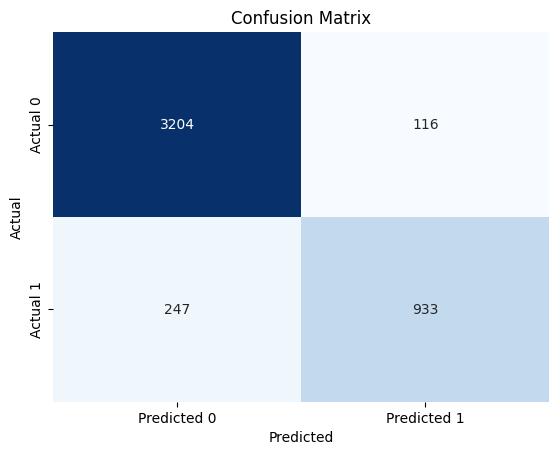

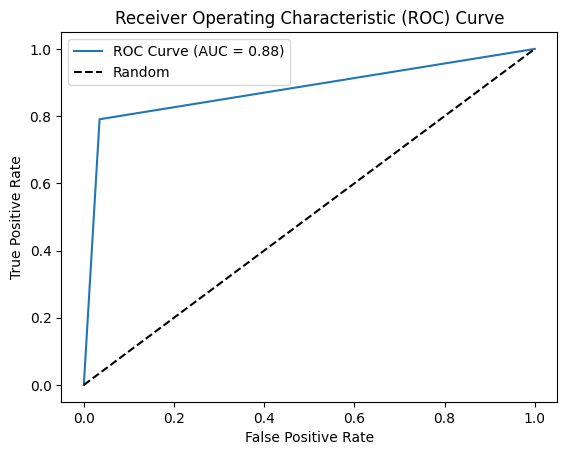

ROC AUC: 0.8779
F1 Score: 0.8371
Confusion Matrix:
[[3204  116]
 [ 247  933]]


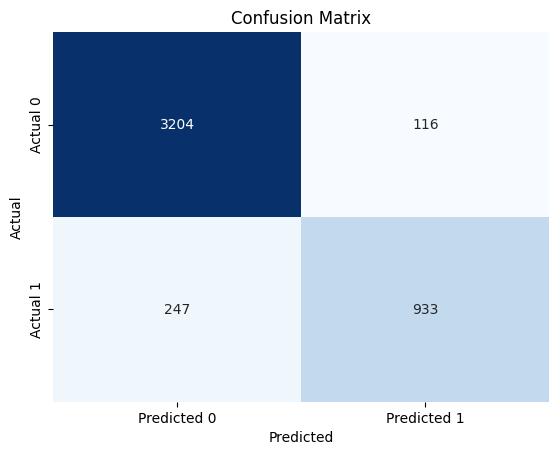

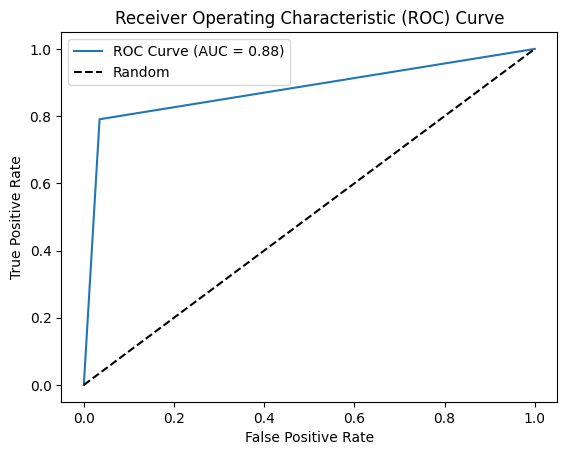

ROC AUC: 0.8779
F1 Score: 0.8371
Confusion Matrix:
[[3204  116]
 [ 247  933]]


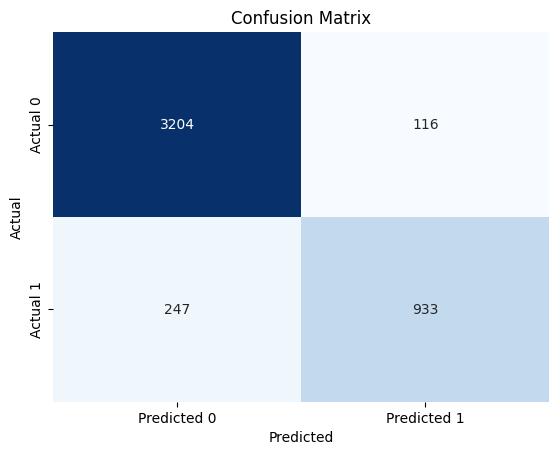

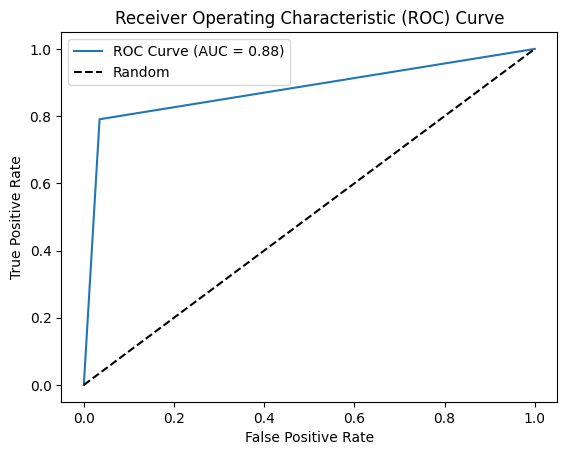

ROC AUC: 0.8779
F1 Score: 0.8371
Confusion Matrix:
[[3204  116]
 [ 247  933]]


In [27]:
scoresn(lll,df,"TEXT","LABEL",logprior)

The best threshold is -0.1891 with an accuracy of 73.80%
The best threshold for F1 score is -13.7293 with an F1 score of 0.44
The best threshold for ROC AUC is -5.8309 with a ROC AUC of 0.59


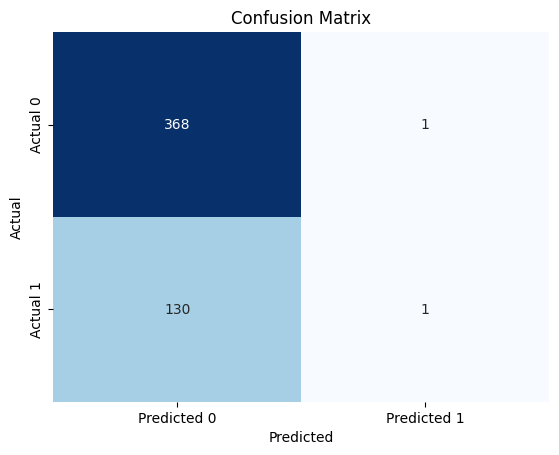

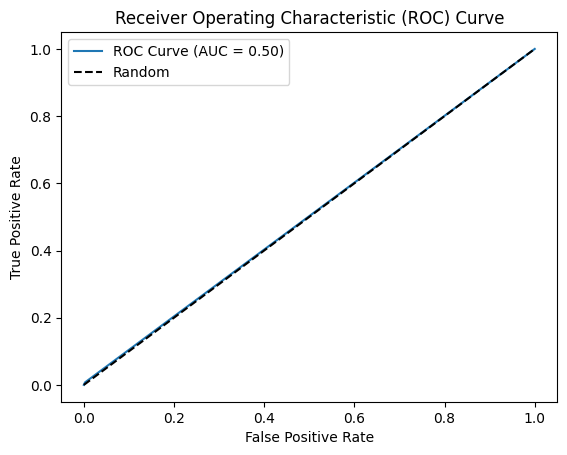

ROC AUC: 0.5025
F1 Score: 0.0150
Confusion Matrix:
[[368   1]
 [130   1]]


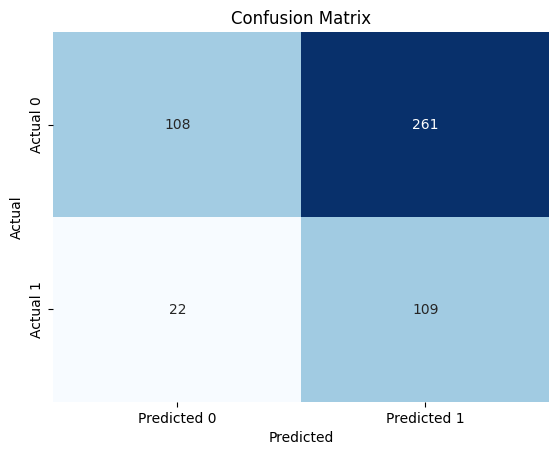

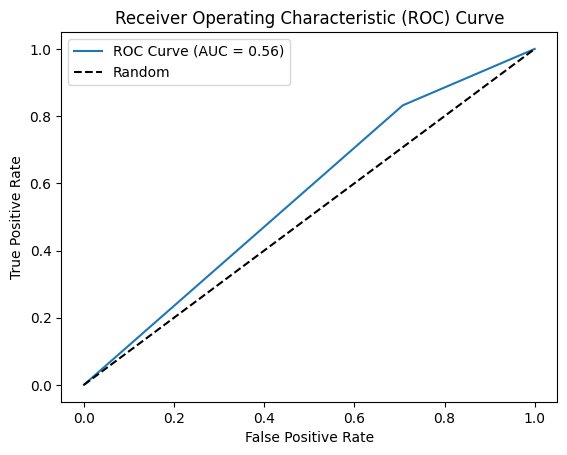

ROC AUC: 0.5624
F1 Score: 0.4351
Confusion Matrix:
[[108 261]
 [ 22 109]]


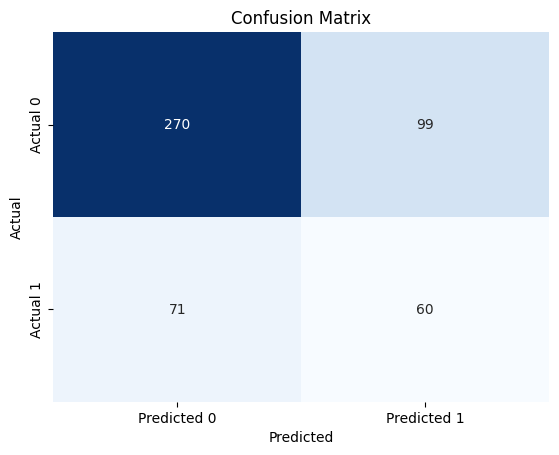

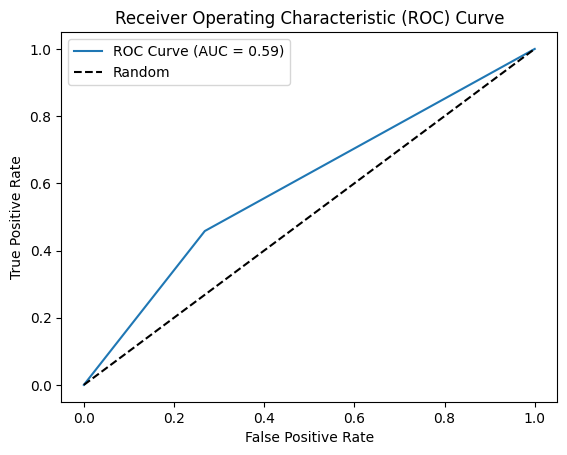

ROC AUC: 0.5949
F1 Score: 0.4138
Confusion Matrix:
[[270  99]
 [ 71  60]]


In [28]:
standard_trigram_no_pos(df,df2,biascol="LABEL",textcol="TEXT",senti=True)

In [ ]:
def incremental_new()